In [1]:
import numpy as np

# Analyze features

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian

from distshift_dataset import UniqueDistshiftDataset
from models import AutoencodingWorldModel, SeparatedAutoencodingWorldModel
from train import get_dataloaders, device
from fim import get_and_save_FIM_data, load_FIM, load_FIM_inv

In [27]:
world_model = AutoencodingWorldModel(.001, hidden_layers=[16, 16, 32], transition_layers=[32])
# world_model.load_state_dict(torch.load(f"data/models/autoencoding_161632.ckpt"))
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}_many.ckpt"))
world_model = world_model.to(device)

In [28]:
def flatten_params(model: nn.Module):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    flat_params = []
    names = []
    for (name, param) in model.named_parameters():
        flat_params.append(torch.flatten(param))
        names.append(name)
    # l = [torch.flatten(p) for p in parameters]
    
    indices = []
    s = 0
    for p in flat_params:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat_params = torch.cat(flat_params).view(-1, 1)
    return {"params": flat_params, "indices": indices, "names": names}


def recover_flattened(flat_params, indices, names, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    from collections import OrderedDict
    
    state_dict = OrderedDict()
    for n, p in zip(names, l):
        state_dict[n] = p
    return state_dict
    # return l

In [29]:
with open(f"data/results/feature_classes_kruskal.json", 'r') as f:
    data = json.load(f)

for k in data.keys():
    p = .05 / len(data[k]['pvalues'])
    print(f"{p=}")
    print(np.all(np.array(data[k]['pvalues']) < p))
    print(np.min(data[k]['pvalues']), np.max(data[k]['pvalues']))


p=0.0010416666666666667
True
2.0781431868613584e-08 5.168592209036863e-05
p=0.0001953125
False
1.4728506814344844e-08 0.0008742138884284172
p=9.765625e-05
False
4.5878052192240353e-08 0.04273665206541064
p=0.0001953125
False
4.8544790695414653e-08 0.026001588075888243
p=0.0010416666666666667
False
5.397727472790887e-07 0.02068382487875043
p=9.765625e-05
True
1.7049735920582868e-08 7.539754204048178e-05


In [30]:
flat_param_dict = flatten_params(world_model)

In [33]:
conv_layers = ['state_encoder.0.net.0.weight',
 'state_encoder.1.net.0.weight',
 'state_encoder.2.net.0.weight',
 'state_decoder.0.net.0.weight',
 'state_decoder.1.net.0.weight',
 'state_decoder.2.weight']

In [91]:
def plot_named_param_std(feature_uncertainties, conv_layers, names, indices):
    features = feature_uncertainties.keys()
    fig, axes = plt.subplots(len(features), len(conv_layers), figsize=(20, 3*len(features)), sharey=True)
    titles = ["Encoder Conv 1", "Encoder Conv 2", "Encoder Conv 3", "Decoder Conv 1", "Decoder Conv 2", "Decoder Conv 3", ]
    
    colors = [(0, 1, 0), "silver", (0, 0, 1), "black", (1, 0, 0)]
    
    legend_lines = {}
    
    for r, feature in enumerate(features):
        offset = 0
        for c, (name, min_max_indices) in enumerate(zip(names, indices)):
            # ax = axes[np.unravel_index(i, (3, 6))]
            if name in conv_layers:
                ax = axes[r, offset]
                model_param_std = feature_uncertainties[feature][min_max_indices[0]:min_max_indices[1]]
                scat = ax.scatter(range(len(model_param_std)), model_param_std, color=colors[r])
                # ax.set_ylim(min_parameter_var, max_parameter_var)
                ax.set_yscale('log')
                # ax.set_ylim(1e-22, 1e-3)
                # ax.set_title(f"Feature {feature}")
                # ax.set_xlabel(titles[offset])
                
                ax.set_xticks([])
                if r == 0:
                    ax.set_title(titles[offset])
                if offset == 0:
                    ax.set_ylabel(r"$\sqrt{var(\theta)}$")
                    legend_lines[feature] = scat
                    
                    
                offset += 1

    plt.tight_layout()

    legend_ax = fig.add_axes([1.02, 0.1, 0.05, 0.8])
    legend_ax.legend(legend_lines.values(), legend_lines.keys(), loc='center left', fontsize=20)
    legend_ax.axis('off')
              
    plt.savefig(f"data/results/feature_classes_uncertainty.png")  
    plt.show()


In [92]:
# dir = f"data/feature_fims_inv/"
# feature_uncertainties = dict()
# for filename in os.listdir(dir):
#     if ".npz" in filename and "next" not in filename:
#         cov = np.load(dir + filename)["arr_0"]
#         print(filename, cov.shape)
#         feature = filename.split('.')[0]
#         param_std = np.sqrt(np.diag(cov))
#         feature_uncertainties[feature] = param_std

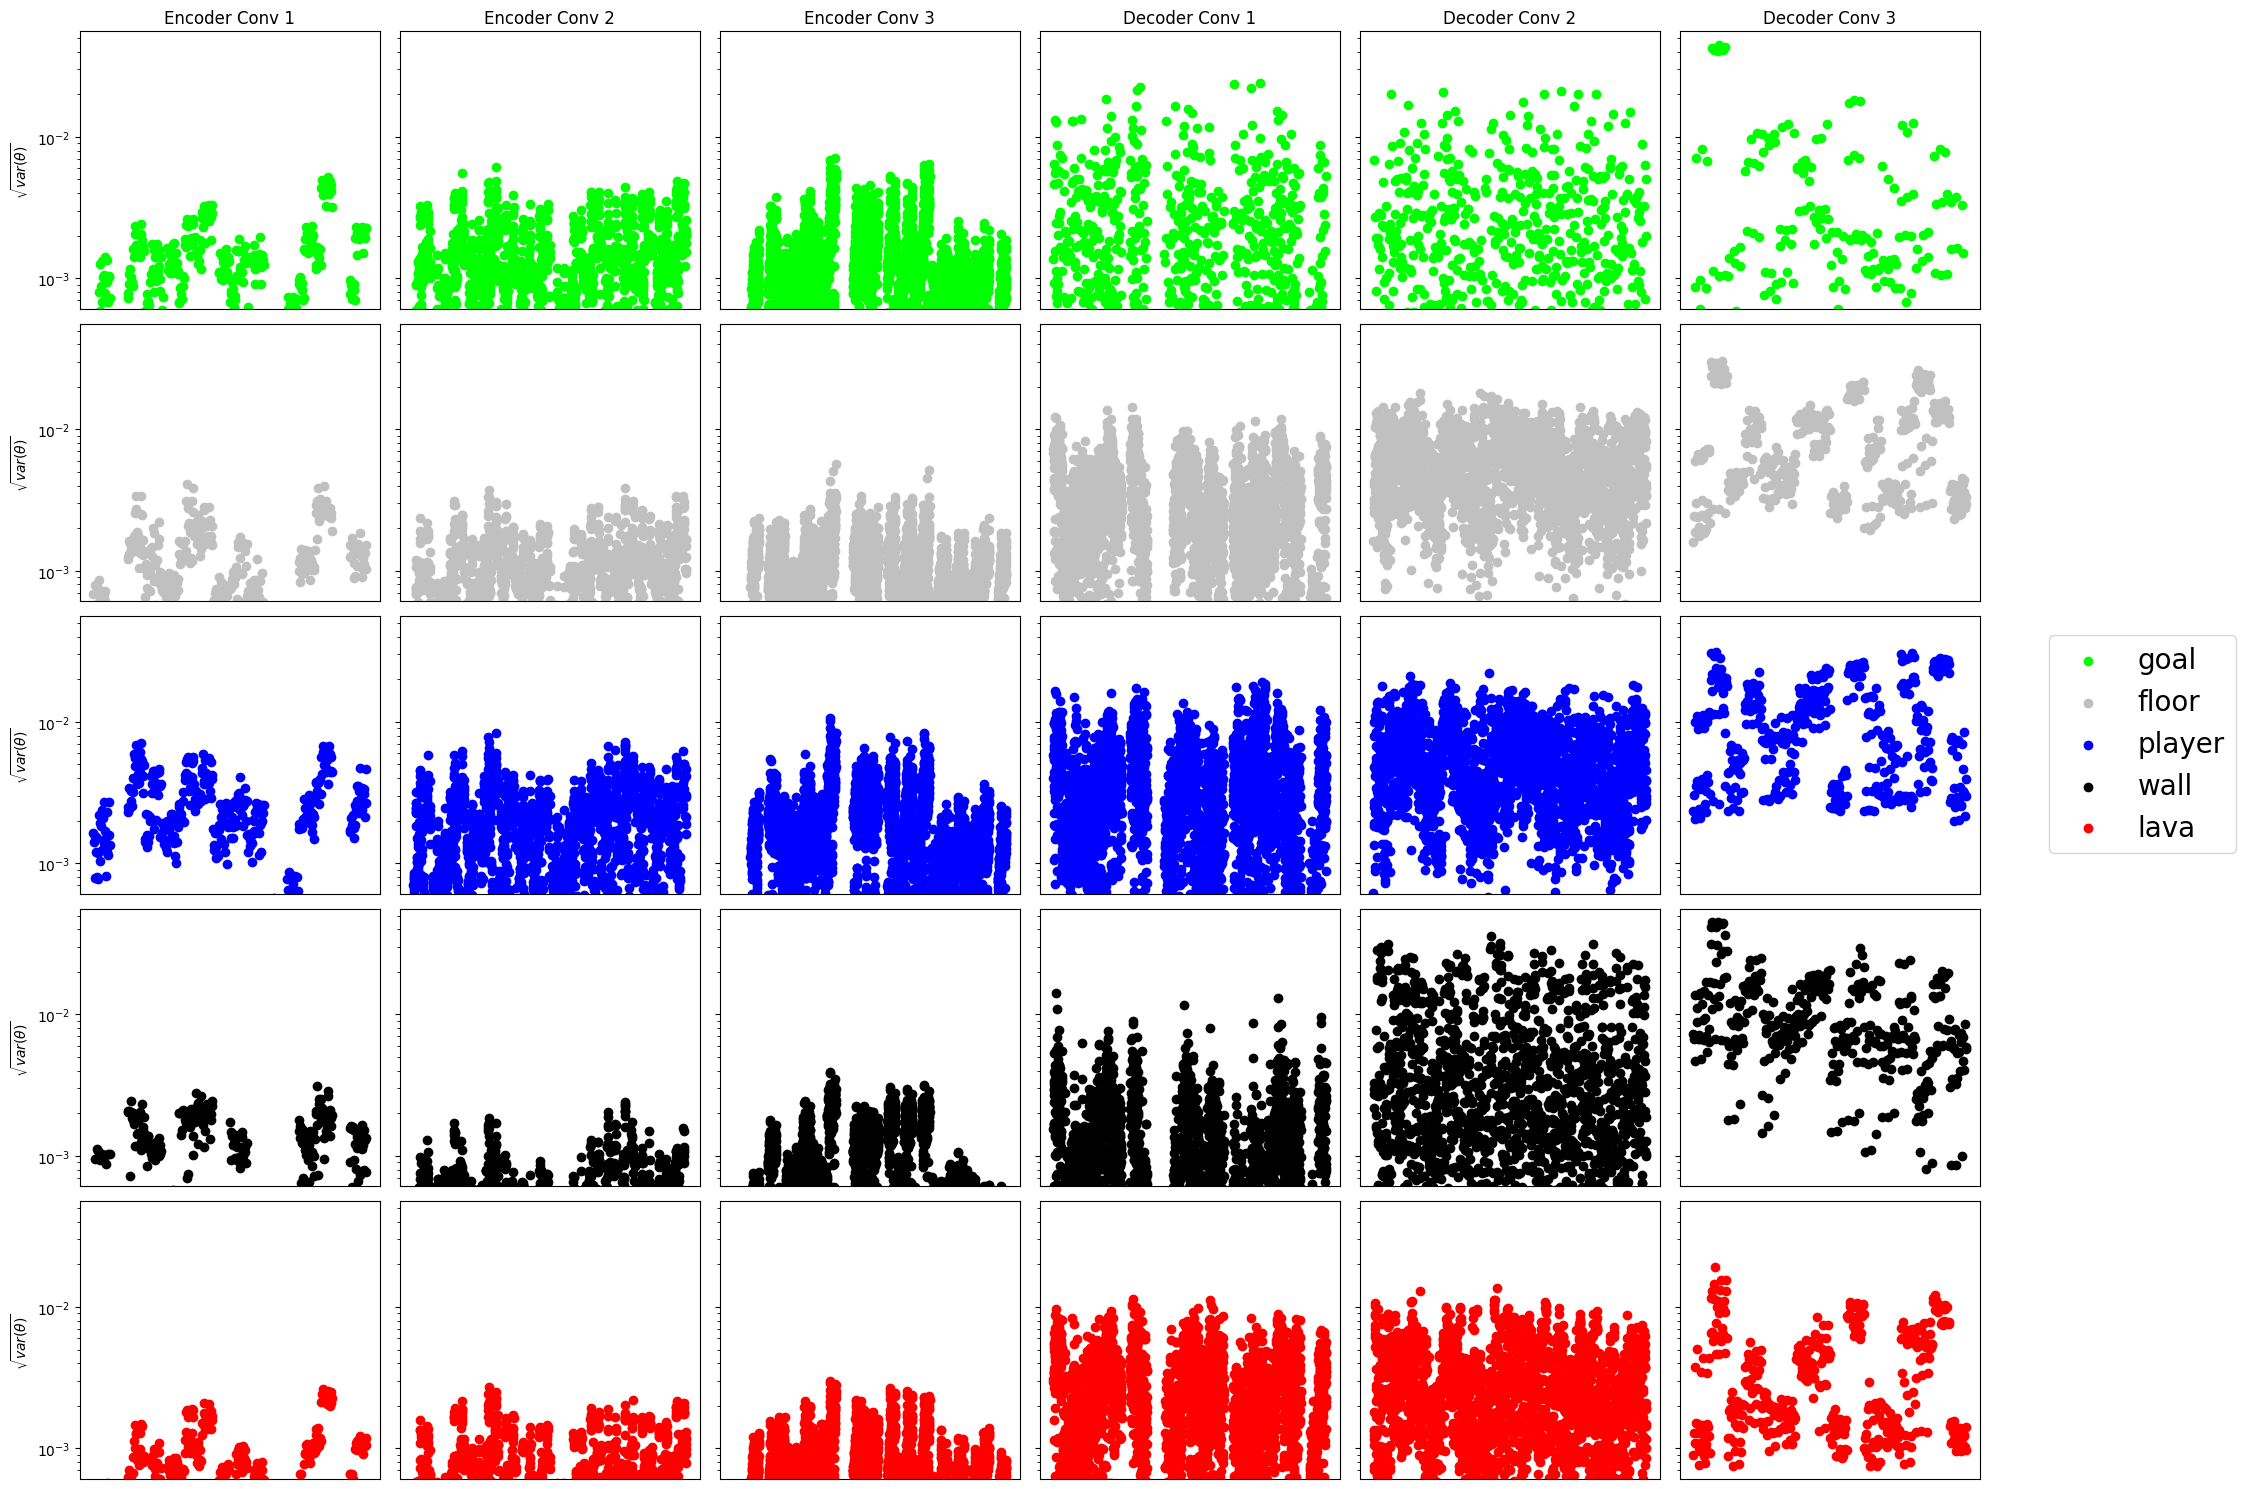

In [93]:
plot_named_param_std(feature_uncertainties, conv_layers, flat_param_dict["names"], flat_param_dict["indices"])

# Reshaping prac

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian

from distshift_dataset import UniqueDistshiftDataset
from models import AutoencodingWorldModel, SeparatedAutoencodingWorldModel
from train import get_dataloaders, device, preprocess
from fim import recover_flattened, load_FIM_inv, flatten_params
# from fim import get_and_save_FIM_data, load_FIM, load_FIM_inv, get_jac_feature_classes
from sloppy import get_reduced_sloppy_model_lowest_highest_analysis, get_reduced_sloppy_model_baseline_analysis, reduced_sloppy_model_analysis

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
import seaborn as sns

In [2]:
world_model = AutoencodingWorldModel(.001, hidden_layers=[16, 16, 32], transition_layers=[32])
# world_model.load_state_dict(torch.load(f"data/models/autoencoding_161632.ckpt"))
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}_many.ckpt"))
world_model = world_model.to(device)

# train_dataset = UniqueDistshiftDataset("distshift-v0")
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
# test_dataset = UniqueDistshiftDataset("distshift-v1")
# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# filenames = [f"distshift-v0", f"distshift-v1"]
# for i in range(1, 5):
#     filenames.append(f"distshift-horz{i}")
#     filenames.append(f"distshift-vert{i}")
# train_dataset = UniqueDistshiftDataset(filenames)
train_dataset = UniqueDistshiftDataset(["distshift-v0", "distshift-v1"])
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [3]:
reduced_sloppy_model_analysis(world_model, train_dataloader, steps=100, remove_most_sloppy=True)
reduced_sloppy_model_analysis(world_model, train_dataloader, steps=100, remove_most_sloppy=False)
get_reduced_sloppy_model_lowest_highest_analysis(world_model, train_dataloader, steps=100)
get_reduced_sloppy_model_baseline_analysis(world_model, train_dataloader, steps=100, n_trials=20)

/home/kane0058/mambaforge/envs/diffusion/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kane0058/mambaforge/envs/diffusion/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/kane0058/mambaforge/envs/diffusion/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kane0058/mambaforge/envs/diffusion/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/kane0058/mambaforge/envs/diffusion/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
df = pd.read_pickle(f"data/results/autoencoding_s_16_16_32_t_32.pickle")
df_reverse = pd.read_pickle(f"data/results/autoencoding_s_16_16_32_t_32_reverse.pickle")
df_lowest = pd.read_pickle(f"data/results/autoencoding_s_16_16_32_t_32_lowest.pickle")
df_highest = pd.read_pickle(f"data/results/autoencoding_s_16_16_32_t_32_highest.pickle")
df_random = pd.read_pickle(f"data/results/autoencoding_s_16_16_32_t_32_random.pickle")

In [5]:
df

,n_eff_params,param_norm,step,param_uncertainty_mean,param_uncertainty_std,param_uncertainty_median,log_param_uncertainty_mean,log_param_uncertainty_std,log_param_uncertainty_median,loss,agent_pos_acc,image_acc
0,17027,13.258158,0,0.002278,3.504233e-03,0.000824,-3.186602,0.805595,-3.084252,0.000197,0.91875,0.986990
1,17016,13.258158,11,0.002280,3.504902e-03,0.000825,-3.185686,0.804984,-3.083705,0.000197,0.91875,0.986990
2,16916,13.258157,111,0.002293,3.510882e-03,0.000833,-3.174651,0.794411,-3.079225,0.000197,0.91875,0.986990
3,16816,13.258157,211,0.002307,3.516884e-03,0.000843,-3.164310,0.785334,-3.074388,0.000197,0.91875,0.986862
4,16716,13.258155,311,0.002320,3.522904e-03,0.000855,-3.154315,0.776941,-3.068210,0.000197,0.91875,0.986862
...,...,...,...,...,...,...,...,...,...,...,...,...
168,316,1.857316,16711,0.017273,4.395192e-03,0.016885,-1.875977,0.652139,-1.772497,0.384285,0.00000,0.000000
169,216,1.503776,16811,0.018283,4.993157e-03,0.018478,-1.901224,0.787445,-1.733344,0.384285,0.00000,0.000000
170,116,1.250718,16911,0.019343,6.591930e-03,0.020607,-2.015495,1.061159,-1.685985,0.334533,0.00000,0.000000
171,16,0.050436,17011,0.008573,1.274346e-02,0.000006,-4.126095,1.728918,-5.252236,0.250000,0.00000,0.000000


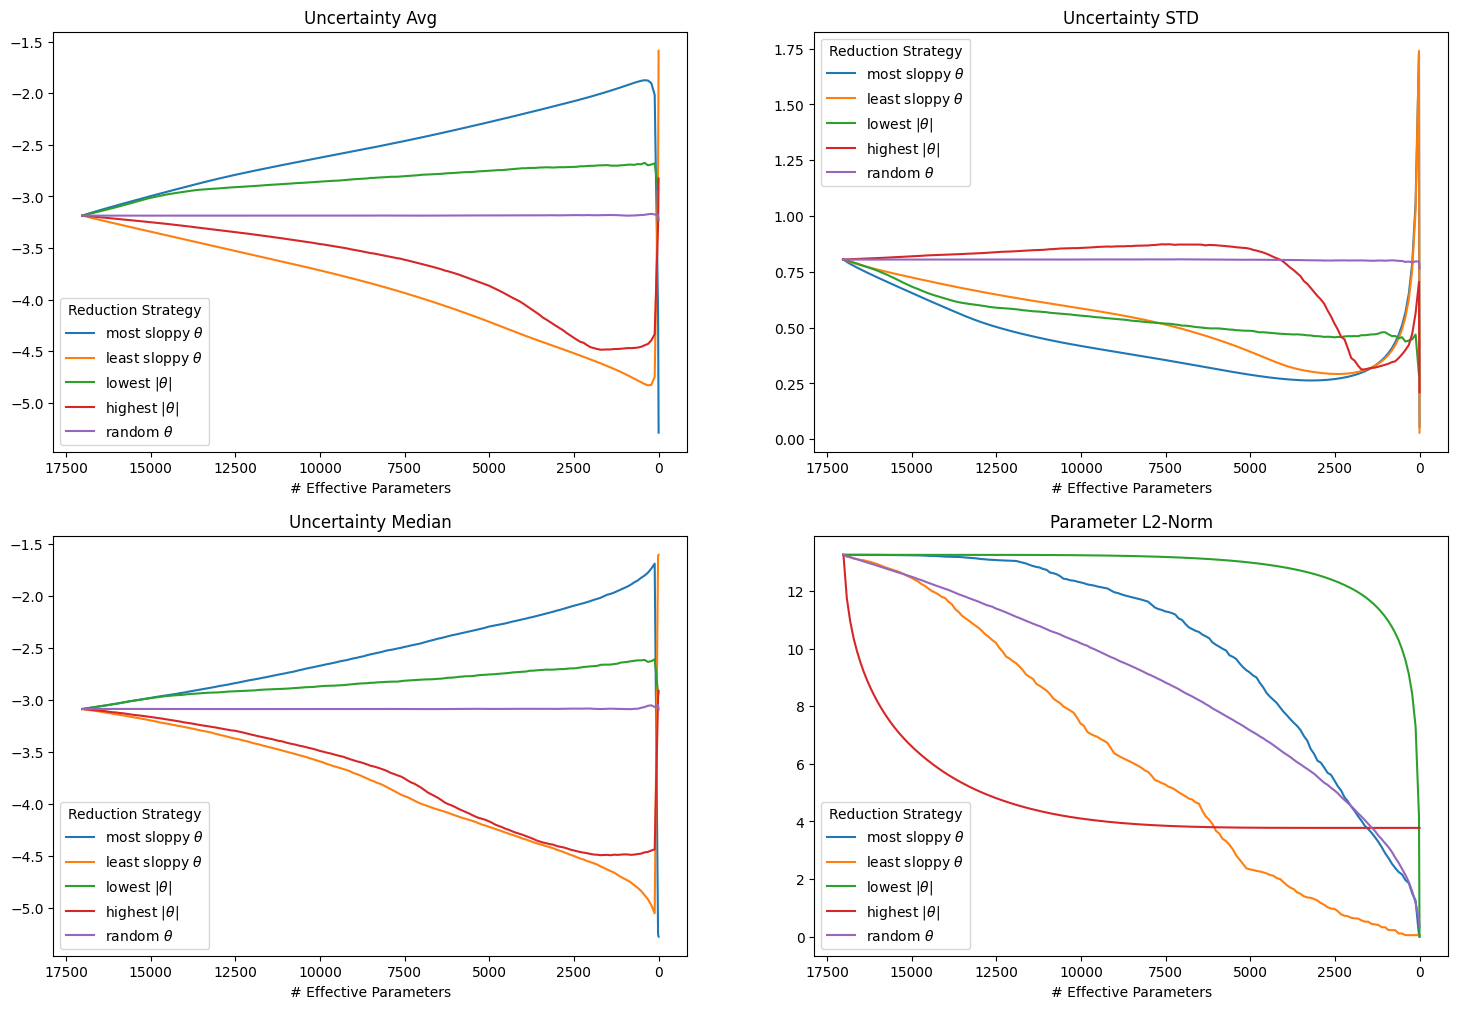

In [6]:
features = ["log_param_uncertainty_mean", "log_param_uncertainty_std", "log_param_uncertainty_median", "param_norm"]
titles = ["Uncertainty Avg", "Uncertainty STD", "Uncertainty Median", "Parameter L2-Norm"]
# ylims=[(-0.01, .4), (-.02, 1.05), (-0.02, 1.05), (-0.1, 14.05)]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i in range(4):
    ax = axes[np.unravel_index(i, (2, 2))]
    feature = features[i]
    
    ax.plot(df["n_eff_params"], df[feature], label=r"most sloppy $\theta$")
    ax.plot(df_reverse["n_eff_params"], df_reverse[feature], label=r"least sloppy $\theta$")
    ax.plot(df_lowest["n_eff_params"], df_lowest[feature], label=r"lowest $| \theta |$")
    ax.plot(df_highest["n_eff_params"], df_highest[feature], label=r"highest $| \theta |$")
    ax.plot(df_random["n_eff_params"], df_random[feature], label=r"random $\theta$")
    # if i < 3:
    #     ax.set_yscale('log')
    ax.set_xlabel("# Effective Parameters")
    # ax.set_ylim(ylims[i])
    ax.invert_xaxis()
    ax.legend(title='Reduction Strategy')
    ax.set_title(titles[i])
# plt.suptitle("Removing Sloppy Parameter")
# plt.show()
plt.show()

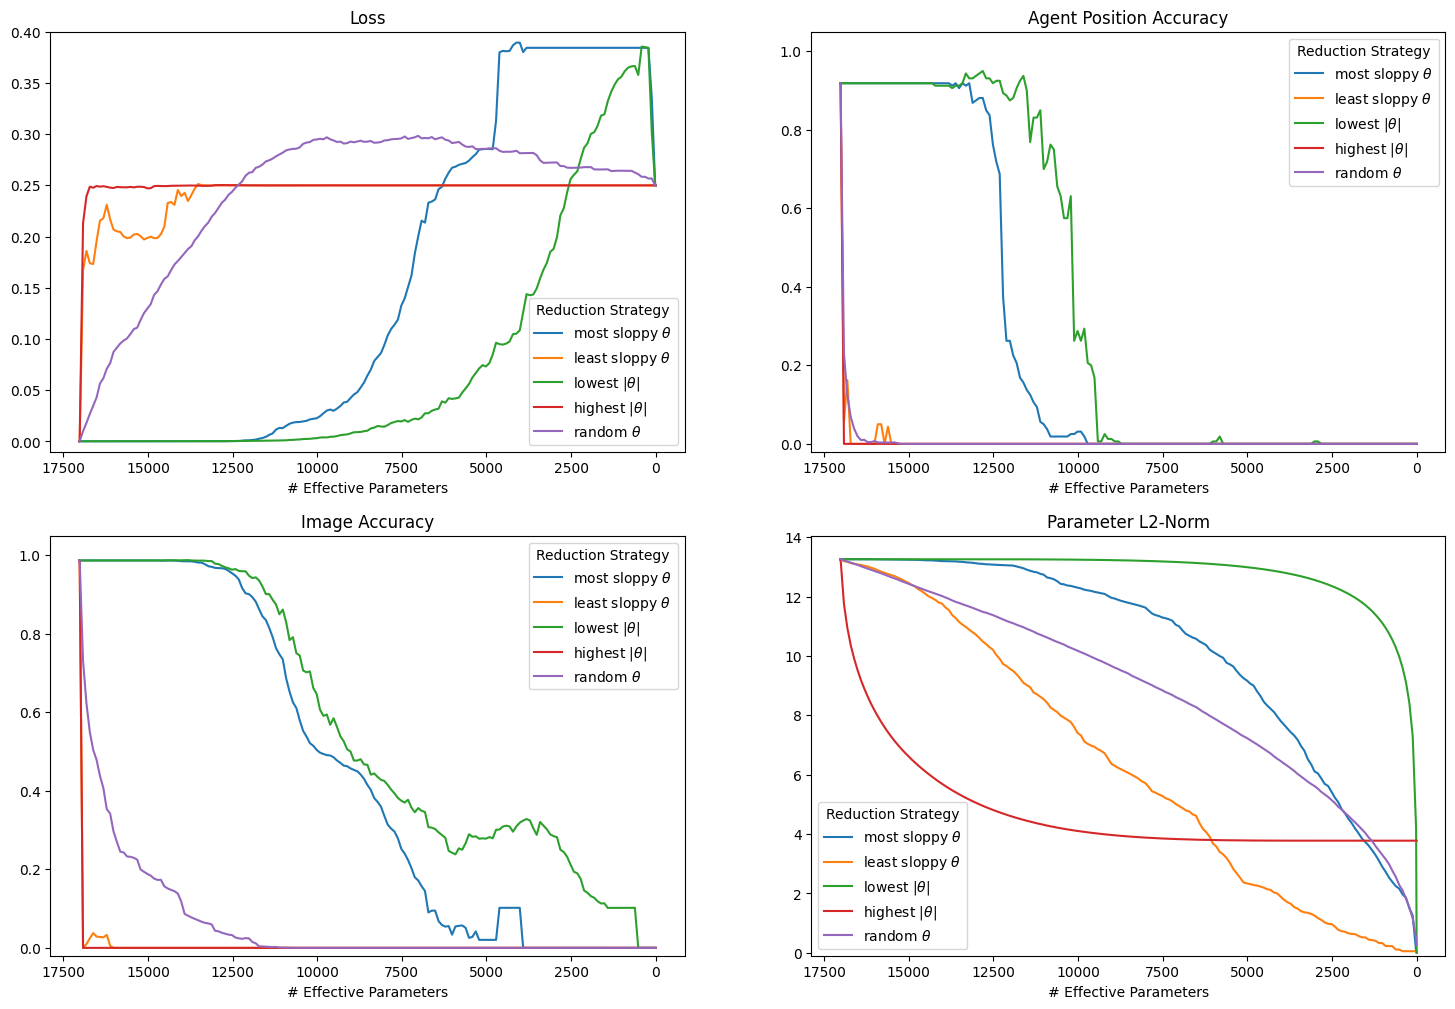

In [19]:
features = ["loss", "agent_pos_acc", "image_acc", "param_norm"]
titles = ["Loss", "Agent Position Accuracy", "Image Accuracy", "Parameter L2-Norm"]
ylims=[(-0.01, .4), (-.02, 1.05), (-0.02, 1.05), (-0.1, 14.05)]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i in range(4):
    ax = axes[np.unravel_index(i, (2, 2))]
    feature = features[i]
    
    ax.plot(df["n_eff_params"], df[feature], label=r"most sloppy $\theta$")
    ax.plot(df_reverse["n_eff_params"], df_reverse[feature], label=r"least sloppy $\theta$")
    ax.plot(df_lowest["n_eff_params"], df_lowest[feature], label=r"lowest $| \theta |$")
    ax.plot(df_highest["n_eff_params"], df_highest[feature], label=r"highest $| \theta |$")
    ax.plot(df_random["n_eff_params"], df_random[feature], label=r"random $\theta$")
    ax.set_xlabel("# Effective Parameters")
    ax.set_ylim(ylims[i])
    ax.invert_xaxis()
    ax.legend(title='Reduction Strategy')
    ax.set_title(titles[i])
# plt.suptitle("Removing Sloppy Parameter")
# plt.show()
plt.savefig(f"data/results/sloppy_model_analysis.png")

In [45]:
@torch.no_grad()
def get_params_and_uncertainty(original_model: AutoencodingWorldModel, strategy="all"):
    import copy
    world_model = copy.deepcopy(original_model)
    FIM_inv = load_FIM_inv(world_model.model_name, strategy)
    parameteric_uncertainty = np.sqrt(np.diag(FIM_inv))
    flat_param_dict = flatten_params(world_model)
    flat_params = flat_param_dict["params"].squeeze().detach().cpu().numpy()
    return flat_params, parameteric_uncertainty

In [34]:
@torch.no_grad()
def get_param_partitions(original_model: AutoencodingWorldModel, strategy="all"):
    import copy
    world_model = copy.deepcopy(original_model)
    FIM_inv = load_FIM_inv(world_model.model_name, strategy)
    parameteric_uncertainty = np.sqrt(np.diag(FIM_inv))
    parameteric_uncertainty_magnitude = np.log(parameteric_uncertainty)
    
    bins = np.linspace(-4.5, -11.5, 8)
    bin_keys = np.linspace(-4, -12, 9)
    
    
    flat_param_dict = flatten_params(world_model)
    flat_params = flat_param_dict["params"].squeeze().detach().cpu().numpy()
    del flat_param_dict
        
    bin_indices = np.digitize(parameteric_uncertainty_magnitude, bins)
    print(bin_indices)

    # Create a dictionary to store the partitioned keys
    partitioned_params = {}
    partitioned_mag = {}
    
    for i, (param, pum) in enumerate(zip(flat_params, parameteric_uncertainty_magnitude)):
        bin_index = bin_indices[i]
        bin_key = bin_keys[bin_index]
        if bin_key not in partitioned_params:
            partitioned_params[bin_key] = []
            partitioned_mag[bin_key] = []
        partitioned_params[bin_key].append(param)
        partitioned_mag[bin_key].append(pum)
    
    return partitioned_params, partitioned_mag

partitioned_params, partitioned_mag = get_param_partitions(world_model)

[3 3 4 ... 0 0 0]


In [35]:
for k in partitioned_mag:
    print(f"key={k}, {np.min(partitioned_mag[k])}, {np.max(partitioned_mag[k])}")

key=-7.0, -7.499972343444824, -6.500573635101318
key=-8.0, -8.498141288757324, -7.500252723693848
key=-9.0, -9.499616622924805, -8.501808166503906
key=-6.0, -6.499920845031738, -5.500799655914307
key=-10.0, -10.499013900756836, -9.500741958618164
key=-5.0, -5.499765396118164, -4.500520706176758
key=-11.0, -11.496177673339844, -10.500188827514648
key=-12.0, -12.841449737548828, -11.500017166137695
key=-4.0, -4.498708724975586, -3.50492787361145


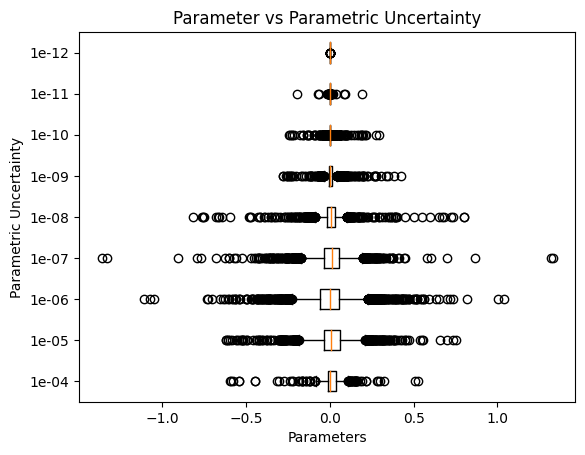

In [72]:
keys = np.linspace(-4, -12, 9)
data = [list(partitioned_params[k]) for k in keys]

plt.xlabel('Parameters')
plt.ylabel('Parametric Uncertainty')
y_tick_labels = []
for k in -1*keys.astype(int):
    k = str(k)
    if len(k) > 1:
        y_tick_labels.append(f'1e-{k}')
    else:
        y_tick_labels.append(f'1e-0{k}')
        
plt.boxplot(data, labels=y_tick_labels, vert=False)
plt.title('Parameter vs Parametric Uncertainty')

plt.savefig(f"data/results/param_vs_param_uncertainty.png")

In [71]:
params, param_uncertainty = get_params_and_uncertainty(world_model)
print("Correlation", scipy.stats.spearmanr(np.abs(params), param_uncertainty)[0])
print("Correlation", scipy.stats.kendalltau(np.abs(params), param_uncertainty)[0])

Correlation 0.5508007122252148
Correlation 0.39174571918249734


# Feature Classes

In [18]:
def get_jac_feature_classes(model, dataset):
    def get_position_to_name(state):
        position_to_name = dict()        
        for r in range(7):
            for c in range(7):
                for color, name in zip(feature_colors, feature_names):
                    if np.all(state[:, r, c] == color):
                        position_to_name[(r, c)] = name
        return position_to_name
                
        
    model = model.eval()
    # batched_states, batched_actions, _, _, _ = next(iter(dataloader))
    feature_names = ["lava", "wall", "floor", "goal", "player"]
    feature_colors = [[255, 0, 0], [0, 0, 0], [255, 255, 255], [0, 255, 0], [0, 0, 255]] 
    state_feature_J = {name: [] for name in feature_names}
    next_state_feature_J = {name: [] for name in feature_names}
    for i in range(len(dataset)):
        s, a, _, _, ns = dataset[i]
        
        state_position_to_names = get_position_to_name(s)
        next_state_position_to_names = get_position_to_name(ns)
        
        s = torch.from_numpy(s).to(device).float().unsqueeze(0)
        a = torch.from_numpy(a).to(device).float().unsqueeze(0)
            
        s = (s / 255) - .5
        predictions = model(s, a)
        
        for r in range(7):
            for c in range(7):
                state_feature_name = state_position_to_names[(r, c)]
                next_state_feature_name = next_state_position_to_names[(r, c)]
                for color in predictions["next_state"][0, :, r, c]:
                    model.zero_grad()
                    color.backward(retain_graph=True)
                    flat_grad = []
                    for param in model.parameters(): 
                        flat_grad.append(param.grad.detach().cpu().numpy().flatten())
                    flat_grad = np.concatenate(flat_grad)
                    
                    if len(state_feature_J[state_feature_name]) >= 20000:
                        if np.random.random() < (1 / (len(dataset) * 5)):
                            i = np.random.randint(20000)    
                            state_feature_J[state_feature_name][i] = flat_grad
                            next_state_feature_J[next_state_feature_name][i] = flat_grad
                    else:
                        state_feature_J[state_feature_name].append(flat_grad)
                        next_state_feature_J[next_state_feature_name].append(flat_grad)
                    
    for name in feature_names:
        state_feature_J[name] = np.stack(state_feature_J[name], axis=0)
        next_state_feature_J[name] = np.stack(next_state_feature_J[name], axis=0)
                    
    return state_feature_J, next_state_feature_J

In [22]:
state_feature_J, next_state_feature_J = get_jac_feature_classes(world_model, train_dataset)

In [23]:
state_feature_J

{'lava': array([[-2.76184781e-03, -2.06302269e-04,  7.69325811e-03, ...,
          7.56292820e-01,  0.00000000e+00,  0.00000000e+00],
        [ 2.80769705e-03, -2.86566815e-03, -1.42471865e-02, ...,
          0.00000000e+00,  7.03918576e-01,  0.00000000e+00],
        [ 9.30974446e-03, -5.94215235e-03, -3.57870534e-02, ...,
          0.00000000e+00,  0.00000000e+00,  7.34424353e-01],
        ...,
        [ 3.13109830e-02,  8.04533213e-02,  6.64940402e-02, ...,
          7.62874842e-01,  0.00000000e+00,  0.00000000e+00],
        [ 1.24408547e-02,  2.36649737e-02,  7.15997443e-03, ...,
          0.00000000e+00,  5.99093199e-01,  0.00000000e+00],
        [-1.79486424e-02, -5.77669665e-02, -6.48869947e-02, ...,
          0.00000000e+00,  0.00000000e+00,  8.83789420e-01]], dtype=float32),
 'wall': array([[-1.7218795e-03, -1.3449732e-03,  1.7401611e-03, ...,
          7.5321674e-01,  0.0000000e+00,  0.0000000e+00],
        [-1.7133232e-03, -1.1909520e-03,  1.9906729e-03, ...,
          0.0000

In [24]:
feature_names = ["lava", "wall", "floor", "goal", "player"]
for name in feature_names:
    print(state_feature_J[name].shape, next_state_feature_J[name].shape)

(9396, 17027) (9180, 17027)
(20000, 17027) (20000, 17027)
(20000, 17027) (21218, 17027)
(2412, 17027) (2361, 17027)
(2412, 17027) (1461, 17027)


In [25]:
def save_feature_fims():
    def save_feature_fim(feature_J, next_state=False):
        FIM = feature_J[name].T @ feature_J[name]
        if next_state:
            np.savez_compressed(f"data/feature_fims/{name}_next_state", FIM)
        else:
            np.savez_compressed(f"data/feature_fims/{name}", FIM)
    
    for name in feature_names:
        save_feature_fim(state_feature_J, next_state=False)    
        save_feature_fim(next_state_feature_J, next_state=True)    
    
save_feature_fims()

In [2]:
def save_feature_fims_inv():
    def save_feature_fim_inv(next_state=False):
        # load_file_dir = "data/feature_fims"
        # save_file_dir = "data/feature_fims_inv"
        # filename = f"data/feature_fims/{name}.npz"
        
        FIM = np.load(f"data/feature_fims/{name}.npz")["arr_0"]
        FIM_inv = scipy.linalg.pinvh(FIM, atol=1e-8)
        
        if next_state:
            np.savez_compressed(f"data/feature_fims_inv/{name}_next_state", FIM_inv)
        else:
            np.savez_compressed(f"data/feature_fims_inv/{name}", FIM_inv)
    
        del FIM
        del FIM_inv
                
            
    feature_names = ["lava", "wall", "floor", "goal", "player"]
    for name in feature_names:
        save_feature_fim_inv(next_state=True)
        save_feature_fim_inv(next_state=False)    

In [3]:
save_feature_fims_inv()

In [46]:
params, param_uncertainty = get_params_and_uncertainty(world_model)

In [49]:
def save_feature_fims_inv():
    def save_feature_fim_inv(next_state=False):
        # load_file_dir = "data/feature_fims"
        # save_file_dir = "data/feature_fims_inv"
        # filename = f"data/feature_fims/{name}.npz"
        
        # FIM_inv = np.load(f"data/feature_fims_inv/{name}.npz")["arr_0"]
        # FIM_inv = scipy.linalg.pinvh(FIM, atol=1e-8)
        
        if next_state:
            # np.savez_compressed(f"data/feature_fims_inv/{name}_next_state", FIM_inv)
            FIM_inv = np.load(f"data/feature_fims_inv/{name}_next_state.npz")["arr_0"]
        else:
            FIM_inv = np.savez_compressed(f"data/feature_fims_inv/{name}", FIM_inv)
    

                
            
    feature_names = ["lava", "wall", "floor", "goal", "player"]
    for name in feature_names:
        save_feature_fim_inv(next_state=True)
        save_feature_fim_inv(next_state=False)    

array([0.00070679, 0.00059299, 0.00052738, ..., 0.01837697, 0.02001008,
       0.02017456], dtype=float32)

In [4]:
import json
with open(f"data/param_var_161632_many.json") as f:
    data = json.load(f)

In [18]:
layer = np.array(data['state_encoder.0.net.0.weight'])

(16, 3, 3, 3)

In [10]:
layer = layer.reshape((48, 9))

In [11]:

# t_statistic, p_value = scipy.stats.ttest_ind(k_1, k_2)
# print(t_statistic, p_value)
# ks_statistic, p_value = scipy.stats.ks_2samp(k_1, k_2)
# print(ks_statistic, p_value)
# k_1 = np.log10(k_1)
# k_2 = np.log10(k_2)
# Perform a t-test
# t_statistic, p_value = scipy.stats.ttest_ind(k_1, k_2)
# print(t_statistic, p_value)
# ks_statistic, p_value = scipy.stats.ks_2samp(k_1, k_2)
# print(ks_statistic, p_value)
h_statistic, p_value = scipy.stats.kruskal(*layer)
print(h_statistic, p_value)

385.6348330624694 1.0012332856493217e-54


In [12]:
print(layer[:5])

[[0.00070679 0.00059299 0.00052738 0.00102252 0.00093764 0.00074458
  0.0012638  0.00114326 0.00061285]
 [0.0009034  0.00070746 0.00048064 0.00078912 0.00092037 0.00050517
  0.00076265 0.00073044 0.00046756]
 [0.00069855 0.00054813 0.00045159 0.00030396 0.00050887 0.0004217
  0.00043649 0.00029806 0.00064379]
 [0.00035907 0.00022998 0.00059229 0.00095215 0.00059577 0.00056385
  0.00021412 0.00064887 0.00057255]
 [0.00080424 0.00033537 0.00095983 0.00074181 0.00071532 0.00080242
  0.00012454 0.00042579 0.000269  ]]
